In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import jax.numpy as jnp
from jax import random, vmap, pmap, local_devices, local_device_count
from jax.scipy.stats import multivariate_normal

from models import VAE
from archs import MLP, periodic_encoding
from utils import restore_checkpoint

from configs.default import get_config

from tqdm.auto import trange
import matplotlib.pyplot as plt
# from matplotlib import style
# style.use('dark_background')
%matplotlib inline

print(local_devices())

2023-01-23 23:31:10.724306: E tensorflow/tsl/lib/monitoring/collection_registry.cc:81] Cannot register 2 metrics with the same name: /tensorflow/core/bfc_allocator_delay


[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]


In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='serif')
plt.rcParams.update({
                      "text.usetex": True,
                      "font.family": "serif",
                      'text.latex.preamble': r'\usepackage{amsmath}',
                      'font.size': 20,
                      'lines.linewidth': 3,
                      'axes.labelsize': 22,  
                      'axes.titlesize': 24,
                      'xtick.labelsize': 20,
                      'ytick.labelsize': 20,
                      'legend.fontsize': 20,
                      'axes.linewidth': 2})

In [3]:
def sample_u(rng_key, X, n):
    k1, k2 = random.split(rng_key)
    mu = random.uniform(k1, (2,), minval=0.0, maxval=1.0)
    sigma = random.uniform(k2, (1,), minval=0.0, maxval=0.01) + 0.001
    u = multivariate_normal.pdf(X, mu, sigma*jnp.eye(2))
    w = 1.0/jnp.linalg.norm(u, 2)**2
    return u.reshape(n,n).T[...,jnp.newaxis], X, u[:,None], jnp.tile(w, (X.shape[0],1))

N = 2048
m = 48
num_channels = 1

x = jnp.linspace(0,1,m)
y = jnp.linspace(0,1,m)
grid = jnp.meshgrid(x,y)
X = jnp.array(grid).T.reshape(-1,2)

# Generate training samples
key = random.PRNGKey(0)
keys = random.split(key, N)
gen_fn = lambda key: sample_u(key, X, m)
u_train, y_train, s_train, w_train = vmap(gen_fn)(keys)
print('Training data')
print('u: {}'.format(u_train.shape))
print('y: {}'.format(y_train.shape))
print('s: {}'.format(s_train.shape))
print('w: {}'.format(w_train.shape))

# Generate testing samples
key = random.PRNGKey(1)
keys = random.split(key, N)
gen_fn = lambda key: sample_u(key, X, m)
u_test, y_test, s_test, w_test = vmap(gen_fn)(keys)
print('Testing data')
print('u: {}'.format(u_test.shape))
print('y: {}'.format(y_test.shape))
print('s: {}'.format(s_test.shape))
print('w: {}'.format(w_test.shape))

Training data
u: (2048, 48, 48, 1)
y: (2048, 2304, 2)
s: (2048, 2304, 1)
w: (2048, 2304, 1)
Testing data
u: (2048, 48, 48, 1)
y: (2048, 2304, 2)
s: (2048, 2304, 1)
w: (2048, 2304, 1)


In [4]:
# Load trained model
config = get_config()
model = VAE(config)
model = restore_checkpoint(model, '../checkpoints/bumps2d_linear_decoder_checkpoint_20000')


                             NeuralOperator Summary                             
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ path          ┃ module        ┃ inputs        ┃ outputs      ┃ params        ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│               │ NeuralOperat… │ -             │ float32[1,1] │               │
│               │               │ float32[1,48… │              │               │
│               │               │ -             │              │               │
│               │               │ float32[1,2]  │              │               │
│               │               │ - float32[32] │              │               │
├───────────────┼───────────────┼───────────────┼──────────────┼───────────────┤
│ encoder       │ ConvEncoder   │ -             │ -            │               │
│               │               │ float32[1,48… │ float32[32]  │               │
│               │          

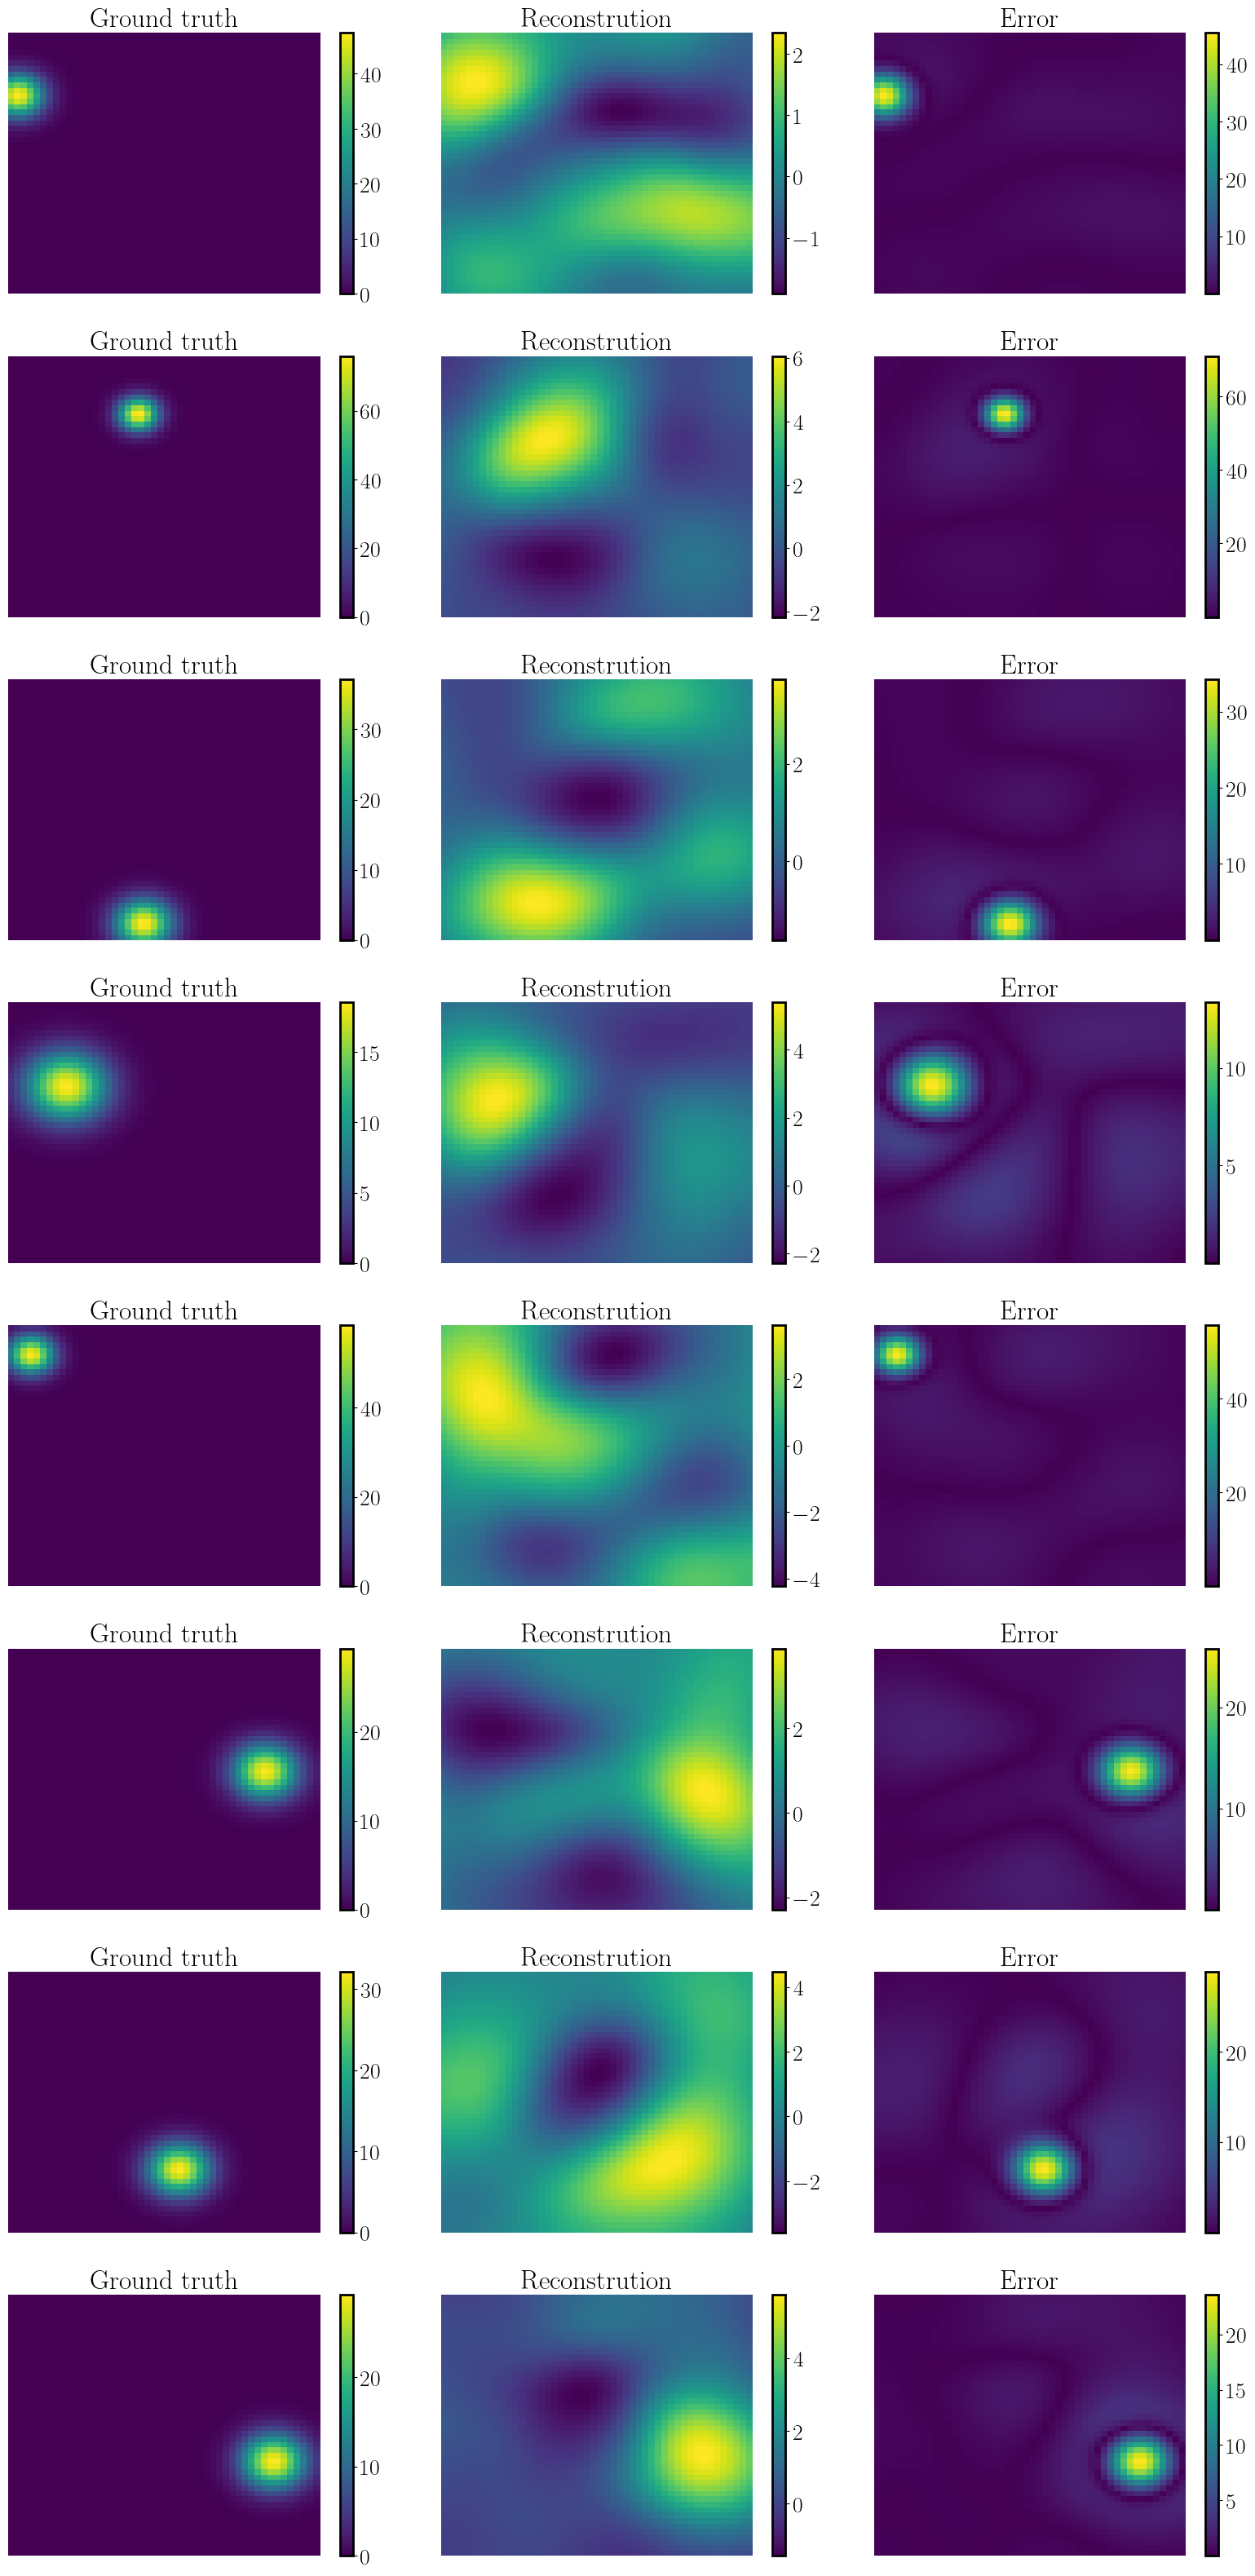

In [5]:
# Train reconstructions
num_samples = 8
key = random.PRNGKey(0)
idx = random.choice(key, N, (num_samples,), replace=False)
eps_train= random.normal(key, (num_samples, config.eps_dim))
pred_fn = lambda params: model.state.apply_fn(params, u_train[idx,...], y_train[idx,...], eps_train)
s_pred = pmap(pred_fn)(model.state.params)[0,...]

num_samples = 8
plt.figure(figsize=(16, num_samples*4))
cnt=0
for i in range(num_samples):
    # Grounf truth
    cnt+=1
    plt.subplot(num_samples, 3, cnt)
    plt.pcolor(grid[0], grid[1], s_train[idx[i],...].reshape(m,m).T)
    plt.colorbar()
    plt.axis('off')
    plt.title('Ground truth')
    # Prediction
    cnt+=1
    plt.subplot(num_samples, 3, cnt)
    plt.pcolor(grid[0], grid[1], s_pred[i,...].reshape(m,m).T)
    plt.colorbar()
    plt.axis('off')
    plt.title('Reconstrution')
    # Error
    cnt+=1
    plt.subplot(num_samples, 3, cnt)
    error = jnp.abs(s_train[idx[i],...] - s_pred[i,...])
    plt.pcolor(grid[0], grid[1], error.reshape(m,m).T)
    plt.colorbar()
    plt.axis('off')
    plt.title('Error')
plt.tight_layout()
plt.savefig('./figures/train_reconstructions.png', dpi=300)
plt.show()

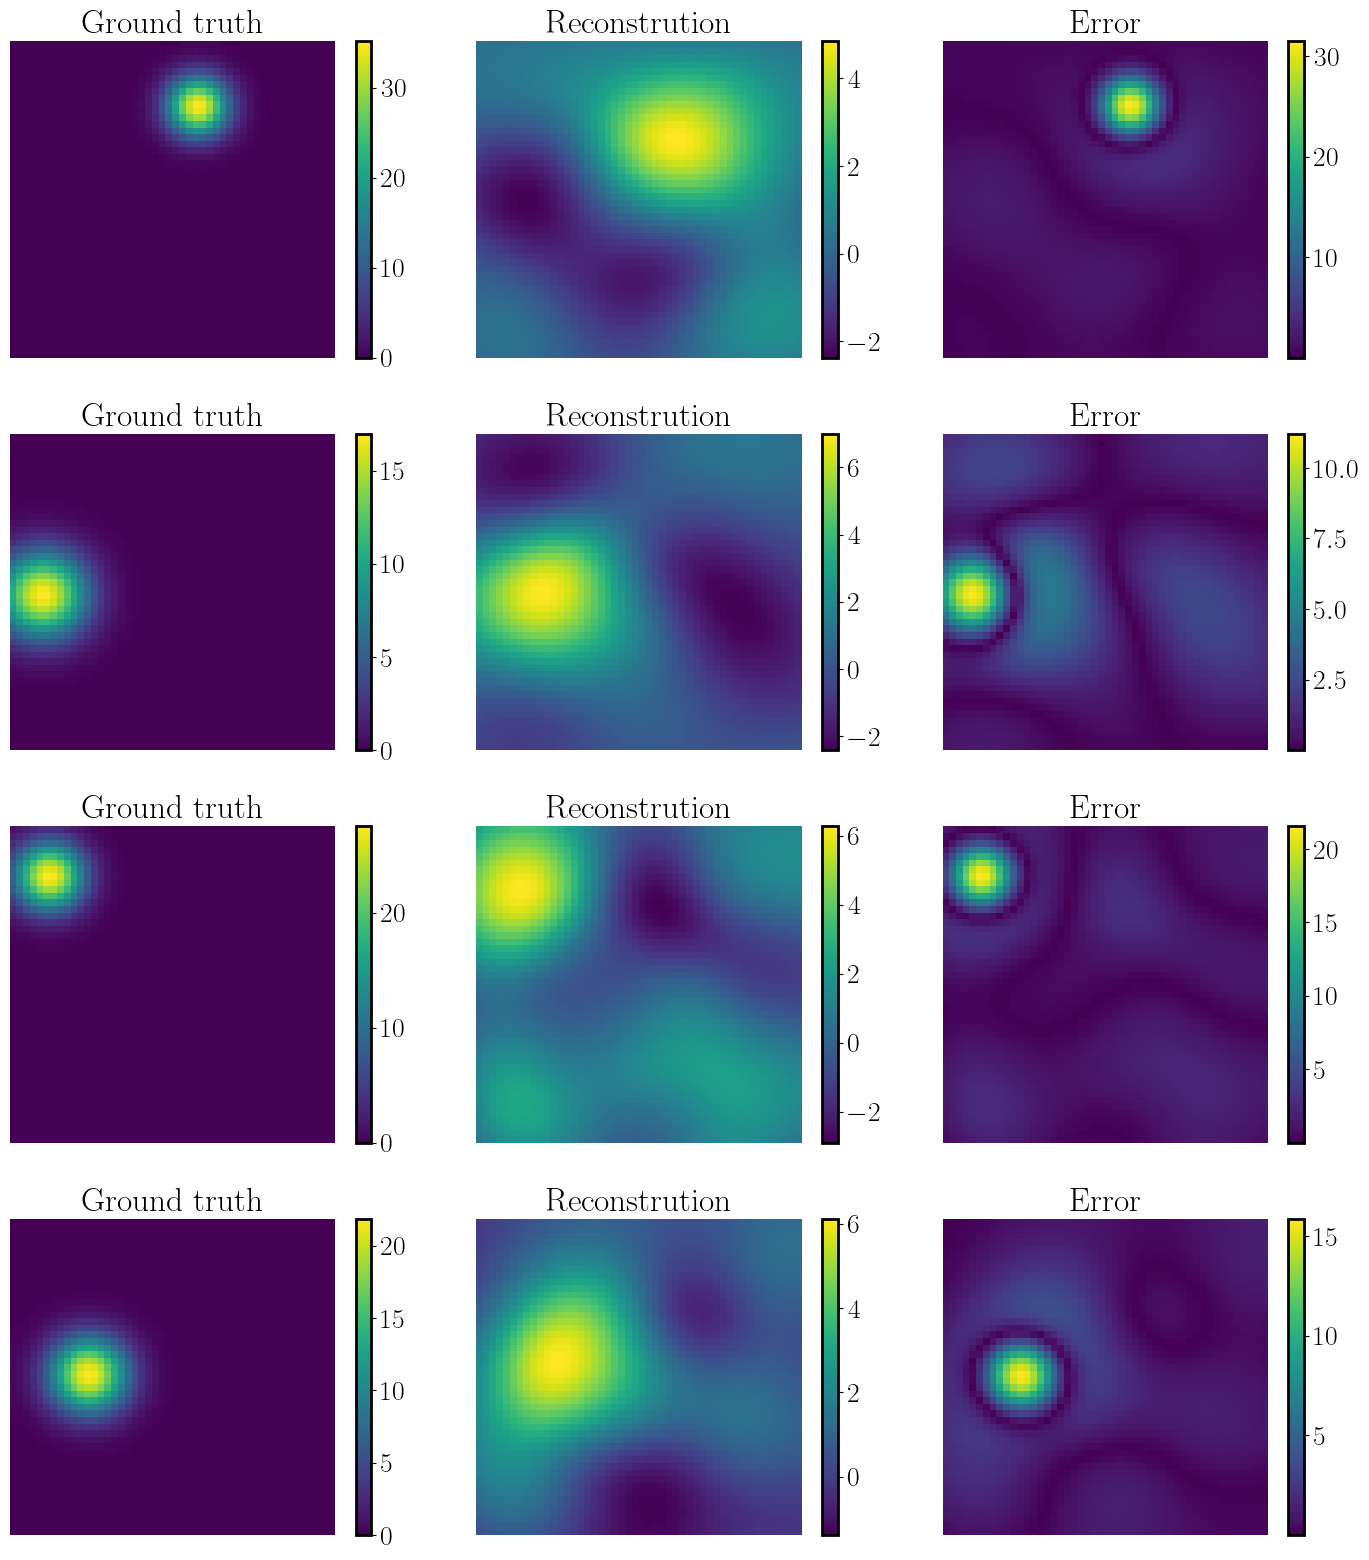

In [6]:
# Test reconstructions
num_samples = 4
key = random.PRNGKey(123)
idx = random.choice(key, N, (num_samples,), replace=False)
eps_test = random.normal(key, (num_samples, config.eps_dim))
pred_fn = lambda params: model.state.apply_fn(params, u_test[idx,...], y_test[idx,...], eps_test)
s_pred = pmap(pred_fn)(model.state.params)[0,...]

plt.figure(figsize=(14,16))
cnt=0
for i in range(num_samples):
    # Grounf truth
    cnt+=1
    plt.subplot(num_samples, 3, cnt)
    plt.pcolor(grid[0], grid[1], s_test[idx[i],...].reshape(m,m).T)
    plt.colorbar()
    plt.axis('off')
    plt.title('Ground truth')
    # Prediction
    cnt+=1
    plt.subplot(num_samples, 3, cnt)
    plt.pcolor(grid[0], grid[1], s_pred[i,...].reshape(m,m).T)
    plt.colorbar()
    plt.axis('off')
    plt.title('Reconstrution')
    # Error
    cnt+=1
    plt.subplot(num_samples, 3, cnt)
    error = jnp.abs(s_test[idx[i],...] - s_pred[i,...])
    plt.pcolor(grid[0], grid[1], error.reshape(m,m).T)
    plt.colorbar()
    plt.axis('off')
    plt.title('Error')
plt.tight_layout()
plt.savefig('./figures/test_reconstructions.png', dpi=300)
plt.show()

In [7]:
# Generate samples
num_samples = 16

# Super-resolution grid
mm = 64
x = jnp.linspace(0,1,mm)
y = jnp.linspace(0,1,mm)
test_grid = jnp.meshgrid(x,y)
y_test = jnp.array(test_grid).T.reshape(-1,2)
y_test = jnp.tile(y_test, (N,1,1))

key = random.PRNGKey(123)
eps_test = random.normal(key, (num_samples, config.eps_dim))
sample_fn = lambda params: model.state.decode_fn(params, eps_test, y_test[:num_samples,...])
samples = pmap(sample_fn)(model.state.params)[0,...]
print(samples.shape)

(16, 4096, 1)


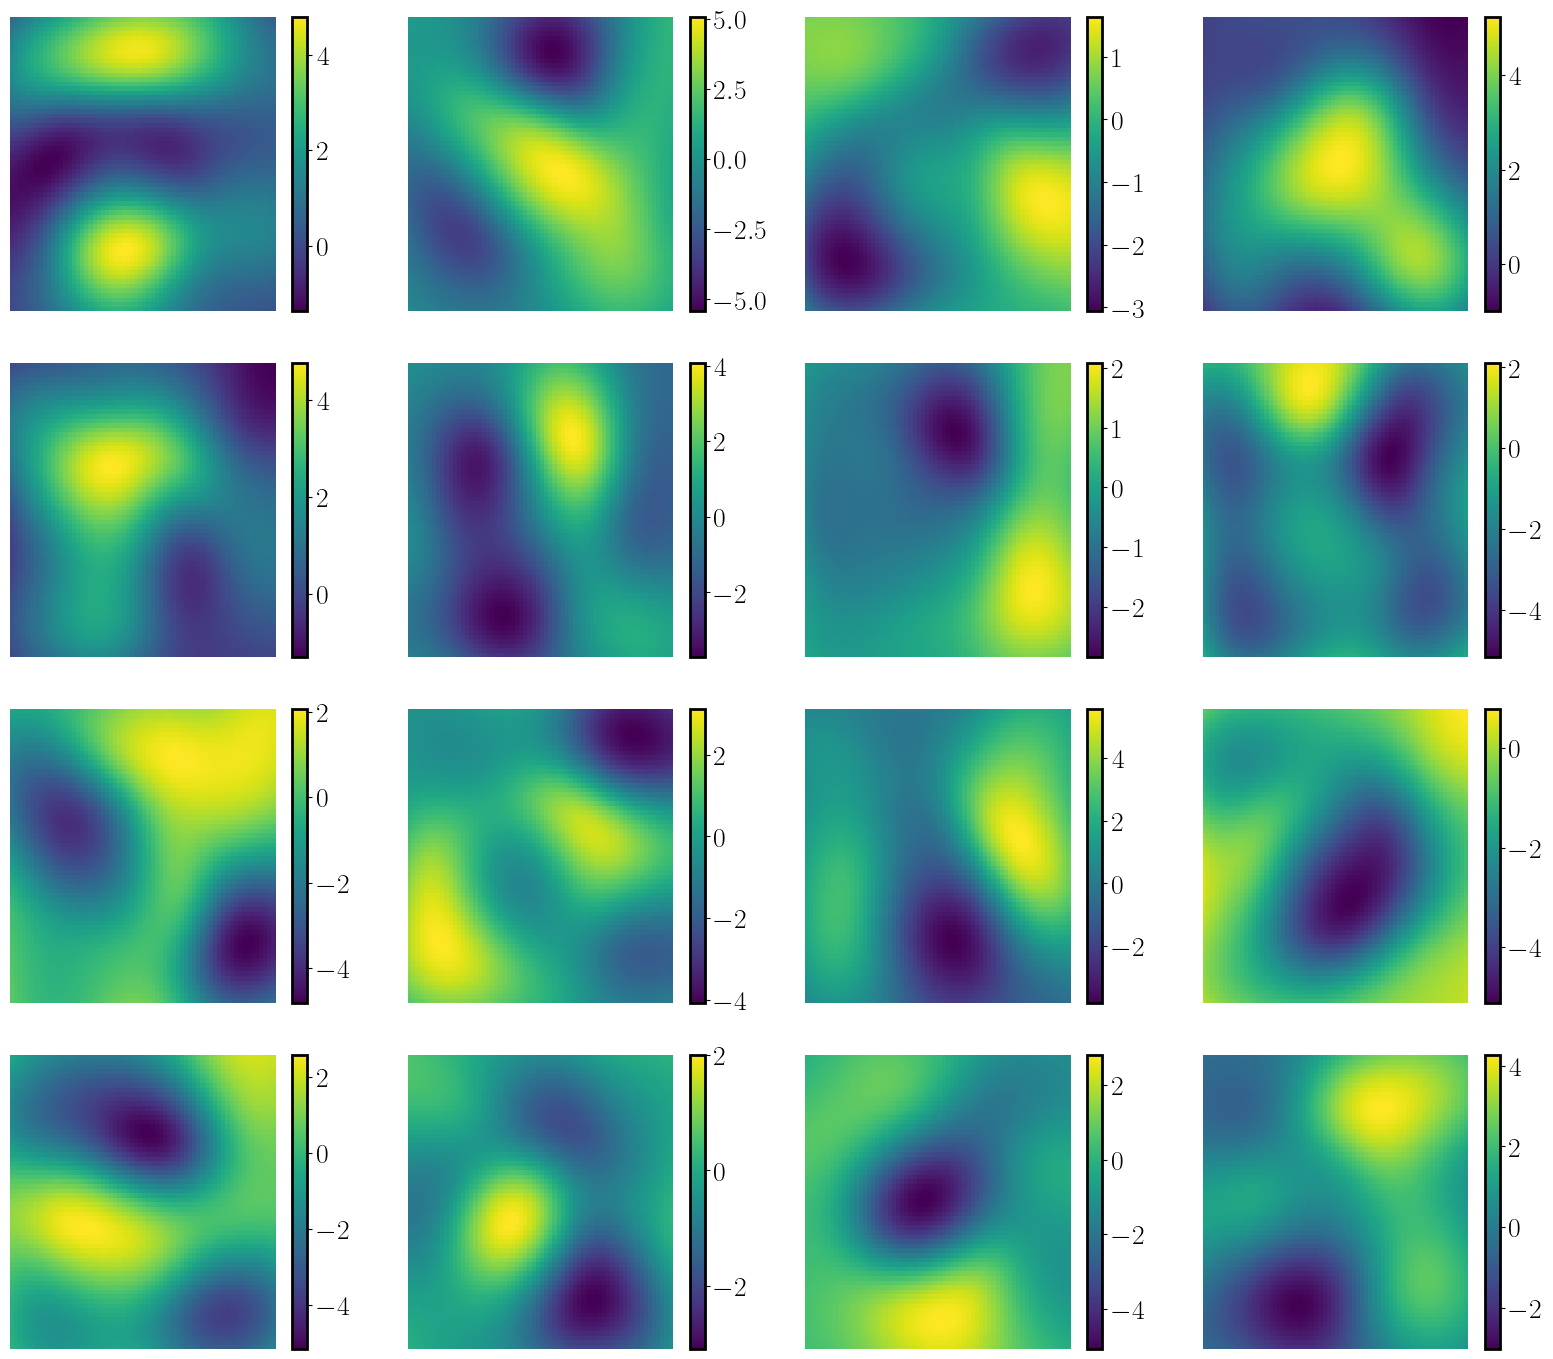

In [8]:
# Plot samples
plt.figure(figsize=(16, 14))
cnt = 0
for i in range(num_samples):
    cnt += 1
    plt.subplot(4, 4, cnt)
    plt.pcolor(test_grid[0], test_grid[1], samples[i,...].reshape(mm,mm).T)
    plt.colorbar()
    plt.axis('off')
plt.tight_layout()
plt.savefig('./figures/samples.png', dpi=300)
plt.show()


In [9]:
def compute_mmd(config, model, num_samples=512):
    # Generate samples from model
    key = random.PRNGKey(123)
    eps_test = random.normal(key, (num_samples, config.eps_dim))
    sample_fn = lambda params: model.state.decode_fn(params, eps_test, y_test[:num_samples,...])
    samples = pmap(sample_fn)(model.state.params)[0,...,0]

    def MMD(X, Y, k):
        n = X.shape[0]
        m = Y.shape[0]
        kXX = k(X,X)
        kYY = k(Y,Y)
        kXY = k(X,Y)
        Xterm = 1./(n*(n-1))*jnp.sum(kXX)
        Yterm = 1./(m*(m-1))*jnp.sum(kYY)
        XYterm = 1./(n*m)*jnp.sum(kXY)
        return Xterm + Yterm - 2*XYterm

    dim = samples.shape[-1]
    kernelfunc = lambda x, y, sigmasq: jnp.exp(- 1./(2*sigmasq*dim) * jnp.dot(x-y, x-y))

    # Define sweep range and containers
    sigmasqs = jnp.logspace(-2,2,100)
    def get_mmds(X, Y, sigmasq):
        kernel = lambda x, y: kernelfunc(x, y, sigmasq)
        k = vmap(vmap(kernel, in_axes=(None, 0)), in_axes=(0, None))
        mmd = MMD(X, Y, k)
        return mmd

    mmds = vmap(get_mmds, in_axes=(None,None,0))(samples, 
                                                 s_test[:num_samples,:,0],
                                                 sigmasqs)
    return mmds

mmds = compute_mmd(config, model)
plt.figure()
plt.plot(jnp.logspace(-2,2,100), mmds)
plt.show()


2023-01-23 23:31:57.268446: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  slice.42 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime.  XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2023-01-23 23:32:00.149117: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 3.880786057s
Constant folding an instruction is taking > 1s:

  slice.42 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't nec

TypeError: sub got incompatible shapes for broadcasting: (512, 1, 4096), (1, 512, 2304).